In [1]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import numpy as np
from sklearn.metrics import accuracy_score,recall_score, precision_score, f1_score
from nltk.stem.porter import PorterStemmer
import spacy
import os
pd.options.mode.chained_assignment = None
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
def filter_text(in_data, field):
  data = in_data.copy()
  for i in range (0,rows):
    oldtext=data[field][i] 
    newtext=' '.join(re.sub("(@[A-Za-z0-9]+)| (_URL_) | (#[A-Za-z0-9]+)|(\w+:\/\/\S+)"," ",str(oldtext)).split()) # removes hashtags, https links, usernames.
    newtext= re.sub('[^a-zA-Z0-9]'," ",str(newtext)) #removes all other characters other than English Alpha-Numeric Characters
    newtext=newtext.lower()
    newtext=newtext.split()
    data[field][i]=newtext
  return data

In [3]:
def porterstemming(in_data):
  data = in_data.copy()
  for i in range (0,rows):
    ps=PorterStemmer()
    oldtext=data[bio_field][i]
    newtext= [ps.stem(word) for word in oldtext if word not in set(stopwords.words('english'))]
    newtext=' '.join(newtext)
    data[bio_field][i]=newtext
  return data

In [4]:
def lemmatization(in_data):
  data = in_data.copy()
  spc = spacy.load("en_core_web_sm")
  for i in range (0,rows):
    oldtext = ' '.join(item for item in data[bio_field][i])
    doc = spc(oldtext)
    newtext=' '.join([str(token) for token in doc if token not in set(stopwords.words("english"))])
    newtext = re.sub(r'\s+', ' ', newtext)
    data[bio_field][i]=newtext
  return data

In [5]:
def create_corpus_and_y(data):
  y=np.array(data["class"])
  corpus=[data[bio_field][i] for i in range(len(data)) if len(data)!=0]
  return (y,corpus)

In [6]:
def count_vec(corpus):
  from sklearn.feature_extraction.text import CountVectorizer
  cv = CountVectorizer(max_features = bag_size)
  X = cv.fit_transform(corpus).toarray()
  return X

In [7]:
def tf_idf_vec(corpus):
  from sklearn.feature_extraction.text import TfidfVectorizer
  vectorizer = TfidfVectorizer(max_features=bag_size) # Add min_df, max_df parameters as well
  vectorizer.fit(corpus)
  X = vectorizer.transform(corpus)
  X=X.toarray()
  return X

In [8]:
from sklearn.decomposition import PCA
def perform_PCA (X_train, y_train, total_components, n_components):
  pca = PCA(n_components=total_components, random_state=0)
  pca.fit(X_train)
  X_pca = pca.transform(X_train)

  print("Variance explained by all", total_components, "principal components =", sum(pca.explained_variance_ratio_ * 100))

  csum = np.cumsum(pca.explained_variance_ratio_ * 100)
  print(csum)
  print ()

  # plot 
  import matplotlib.pyplot as plt
  plt.plot(csum)
  plt.xlabel('Number of components')
  plt.ylabel('Explained variance')
  #plt.savefig('elbow_plot.png', dpi=100)

  # find the number of components
  print (csum[n_components-1])

  x_train_pca=[x[:n_components] for x in X_pca]

  print (len(x_train_pca[0]))
  print ()

  return x_train_pca

In [9]:


class Data:
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

class Result:
    def __init__(self, y_test, y_pred, label=None):
        self.label = label
        self.accuracy = accuracy_score(y_test,y_pred) * 100
        self.precision = precision_score(y_test, y_pred, average='binary') * 100
        self.recall = recall_score(y_test, y_pred, average='binary') * 100
        self.f1 = f1_score(y_test, y_pred, average='binary') * 100
        self.confusion_matrix = confusion_matrix(y_test, y_pred)
        
    def show(self):
        print("Accuracy = ",self.accuracy,"%")
        print("Precision = ",self.precision)
        print("Recall = ",self.recall)
        print("F1 Score = ",self.f1)
        print("Confusion Matrix: \n", self.confusion_matrix)
        
def getResult(data, res):
    result = Result(data.y_test, res)
    result.show()
    return result

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer

def getBestModel(data, model, param_grid, cv=10):
    scorer = make_scorer(metrics.f1_score , average='binary')
    grid = GridSearchCV(model, 
                        param_grid,
                        cv=cv,
                        scoring=scorer)


    grid.fit(data.x_train, data.y_train)
    
    return grid

In [10]:
#Bio

In [11]:
bag_size = 2000
bio_file_prefix = 'bio'
bio_field = 'user description'

In [12]:
csvname=bio_file_prefix+".csv" #changed
# csvname=file_prefix+".csv" #changed
bio_data_orig=pd.read_csv(csvname)
bio_data=bio_data_orig.copy()
bio_data.drop(bio_data.columns[bio_data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
rows=len(bio_data)

In [13]:
filtered_bio_data=filter_text(bio_data, bio_field)
filtered_bio_data

,user description,class
0,"[mother, of, 4, ex, wife, of, 3, battling, hea...",0
1,"[wchs, tv, serves, the, charleston, huntington...",0
2,"[patient, engagement, revenue, cycle, manageme...",0
3,"[home, of, the, minnesota, and, always, live, ...",0
4,"[spectrum, news, 1, offers, the, best, 24, hou...",0
...,...,...
5782,[none],1
5783,[none],1
5784,"[hermit, who, loves, to, read, and, has, 4, do...",1
5785,"[a, well, educated, mind, will, always, have, ...",1


In [14]:
portered_stemmed_data=porterstemming(filtered_bio_data)
portered_stemmed_data

,user description,class
0,mother 4 ex wife 3 battl health inequ misinfor...,0
1,wch tv serv charleston huntington market lates...,0
2,patient engag revenu cycl manag healthcar thou...,0
3,home minnesota alway live free app,0
4,spectrum news 1 offer best 24 hour local news ...,0
...,...,...
5782,none,1
5783,none,1
5784,hermit love read 4 dog like peopl,1
5785,well educ mind alway question answer helen keller,1


In [15]:
y_portered,portered_corpus=create_corpus_and_y(portered_stemmed_data)


In [16]:
X_portered_TF_IDF=tf_idf_vec(portered_corpus)


In [17]:
df_portered_TF_IDF = pd.DataFrame(X_portered_TF_IDF)
df_portered_TF_IDF['class'] = y_portered
df_portered_TF_IDF

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [18]:
# def split_data_train_test_split(X,y):
#  from sklearn.model_selection import train_test_split
#  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#  return(X_train, X_test,y_train,y_test)

import math
from sklearn.model_selection import train_test_split

def split_data_train_test_split(X,y):
    X_class = {
        0: [],
        1: []}
    for i in range(len(y)):
        X_class[y[i]].append(X[i])
    X_0_candidate = X_class[0][:len(X_class[1])]
    X_0_add = X_class[0][len(X_class[1]):]
    
    X_candidate = np.concatenate((X_0_candidate, X_class[1]))
    
    y_candidate = np.array([0 for i in range(len(X_0_candidate))])
    y_candidate = np.concatenate((y_candidate,np.array([1 for i in range(len(X_0_candidate))])))

    y_0_add = np.array([0 for i in range(len(X_0_add))])
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_candidate, y_candidate, test_size = 0.2, random_state = 0)

#     X_test = np.concatenate((X_test, X_0_add))
#     y_test = np.concatenate((y_test, y_0_add))
    
    return(X_train, X_test,y_train,y_test)

In [19]:
# PCA on portered data
y = df_portered_TF_IDF['class']
X_portered_tf = df_portered_TF_IDF.copy()
X_portered_tf.drop ('class', axis=1, inplace=True)


0.05
Variance explained by all 2000 principal components = 100.0000000000001
[ 11.98809217  13.10239091  13.95960529 ... 100.         100.
 100.        ]

96.26887506033768
1350



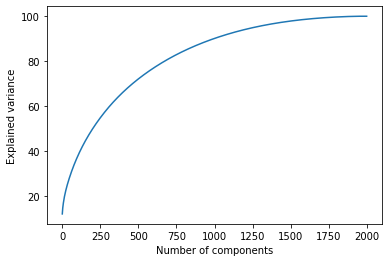

In [20]:
# PCA portered TF IDF
total_components = len(X_portered_tf.columns)
print (100/total_components)
n_components = 1350
X_portered_tf_PCA_bio = perform_PCA (X_portered_tf, y, total_components, n_components)

In [21]:
X_train_portered_tf_bio, X_test_portered_tf_bio,y_train_portered_tf_bio,y_test_portered_tf_bio=split_data_train_test_split(X_portered_tf_PCA_bio,y)

In [22]:
from sklearn.svm import SVC
svclassifier_bio = SVC(C= 0.5, gamma= 1, kernel= 'linear',probability=True)
svclassifier_bio.fit(X_train_portered_tf_bio, y_train_portered_tf_bio)
y_pred_bio = svclassifier_bio.predict(X_test_portered_tf_bio)


In [23]:
#hashtags

In [24]:
file_prefix = 'hashtag'
bio_field = 'hashtag'
bag_size = 1500

In [25]:
csvname=file_prefix+".csv" #changed
data_orig=pd.read_csv(csvname)
data=data_orig.copy()
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
rows=len(data)

0.13368983957219252
Variance explained by all 748 principal components = 99.99999999999972
[ 56.2576796   63.96896201  65.68928171  66.3346172   66.95406219
  67.55719448  68.12584803  68.68548118  69.2180204   69.73447458
  70.12049119  70.5020421   70.88002144  71.24843564  71.60348565
  71.94175492  72.26416827  72.56682012  72.86035717  73.13458884
  73.38756977  73.63765459  73.88071438  74.12221822  74.36192388
  74.59608265  74.82780423  75.05796508  75.28445657  75.50043225
  75.70505902  75.90650463  76.10297563  76.2862819   76.46869533
  76.64434539  76.81821177  76.98915245  77.1575547   77.32118037
  77.483559    77.6452512   77.80259038  77.95690886  78.10806409
  78.25327385  78.3974595   78.53457951  78.67169951  78.80881952
  78.94593952  79.08305952  79.22017953  79.3568919   79.49098152
  79.62398248  79.75485095  79.88425191  80.01256884  80.14037303
  80.26782524  80.39146057  80.51420363  80.6328581   80.75134648
  80.86924559  80.98660621  81.10329501  81.2183089

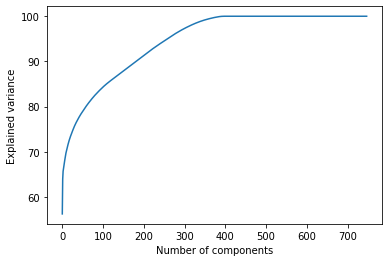

In [26]:
filtered_data=filter_text(data,bio_field)
# filtered_data

portered_stemmed_data=porterstemming(filtered_data)
# portered_stemmed_data

lemmatization_data=lemmatization(filtered_data)
# lemmatization_data

y_portered,portered_corpus=create_corpus_and_y(portered_stemmed_data)
y_lemmatization,lemmatization_corpus=create_corpus_and_y(lemmatization_data)

X_portered_CV=count_vec(portered_corpus)
X_lemmatization_CV=count_vec(lemmatization_corpus)

df_portered_CV = pd.DataFrame(X_portered_CV)
df_portered_CV['class'] = y_portered
# df_portered_CV

df_lemmatization_CV = pd.DataFrame(X_lemmatization_CV)
df_lemmatization_CV['class'] = y_lemmatization
# df_lemmatization_CV

X_portered_TF_IDF=tf_idf_vec(portered_corpus)
X_lemmatization_TF_IDF=tf_idf_vec(lemmatization_corpus)

df_portered_TF_IDF = pd.DataFrame(X_portered_TF_IDF)
df_portered_TF_IDF['class'] = y_portered
# df_portered_TF_IDF

df_lemmatization_TF_IDF = pd.DataFrame(X_lemmatization_TF_IDF)
df_lemmatization_TF_IDF['class'] = y_lemmatization
# df_lemmatization_TF_IDF

# PCA on portered data
y = df_portered_TF_IDF['class']
X_portered_tf = df_portered_TF_IDF.copy()
X_portered_tf.drop ('class', axis=1, inplace=True)

X_portered_cv = df_portered_CV.copy()
X_portered_cv.drop ('class', axis=1, inplace=True)

# PCA portered TF IDF
total_components = min(len(df_portered_TF_IDF.columns)-1, len(X_portered_tf))
print (100/total_components)
n_components = 300
X_portered_tf_PCA_hashtag = perform_PCA (X_portered_tf, y, total_components, n_components)

X_train_portered_tf_hashtag, X_test_portered_tf_hashtag,y_train_portered_tf_hashtag,y_test_portered_tf_hashtag=split_data_train_test_split(X_portered_tf_PCA_hashtag,y)

In [27]:
from sklearn.svm import SVC
svclassifier_hashtag = SVC(C= 1, gamma= 1, kernel= 'poly',probability=True)
svclassifier_hashtag.fit(X_train_portered_tf_hashtag, y_train_portered_tf_hashtag)
y_pred_hashtag = svclassifier_hashtag.predict(X_test_portered_tf_hashtag)

In [28]:
#Tweets
file_prefix = 'tweet'
bio_field = 'text'
bag_size = 2000

# load data
# csvname="filtered_dataset/"+file_prefix+".csv" #changed
csvname=file_prefix+".csv" #changed
data_orig=pd.read_csv(csvname)
data=data_orig.copy()
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
rows=len(data)

filtered_data=filter_text(data, bio_field)
# filtered_data

portered_stemmed_data=porterstemming(filtered_data)
# portered_stemmed_data

lemmatization_data=lemmatization(filtered_data)
# lemmatization_data

y_portered,portered_corpus=create_corpus_and_y(portered_stemmed_data)
y_lemmatization,lemmatization_corpus=create_corpus_and_y(lemmatization_data)

X_portered_CV=count_vec(portered_corpus)
X_lemmatization_CV=count_vec(lemmatization_corpus)

df_portered_CV = pd.DataFrame(X_portered_CV)
df_portered_CV['class'] = y_portered
# df_portered_CV

df_lemmatization_CV = pd.DataFrame(X_lemmatization_CV)
df_lemmatization_CV['class'] = y_lemmatization
# df_lemmatization_CV

X_portered_TF_IDF=tf_idf_vec(portered_corpus)
X_lemmatization_TF_IDF=tf_idf_vec(lemmatization_corpus)

df_portered_TF_IDF = pd.DataFrame(X_portered_TF_IDF)
df_portered_TF_IDF['class'] = y_portered
# df_portered_TF_IDF

df_lemmatization_TF_IDF = pd.DataFrame(X_lemmatization_TF_IDF)
df_lemmatization_TF_IDF['class'] = y_lemmatization
# df_lemmatization_TF_IDF

0.05
Variance explained by all 2000 principal components = 99.99999999999991
[  2.86549313   4.97604969   6.36904749 ... 100.         100.
 100.        ]

96.04827219751017
1350



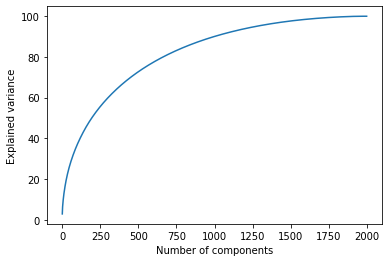

In [29]:
# PCA on portered data
y = df_portered_TF_IDF['class']
X_portered_tf = df_portered_TF_IDF.copy()
X_portered_tf.drop ('class', axis=1, inplace=True)

X_portered_cv = df_portered_CV.copy()
X_portered_cv.drop ('class', axis=1, inplace=True)

# PCA portered TF IDF
total_components = min(len(df_portered_TF_IDF.columns)-1, len(X_portered_tf))
print (100/total_components)
n_components = 1350
X_portered_tf_PCA_text = perform_PCA (X_portered_tf, y, total_components, n_components)

X_train_portered_tf_text, X_test_portered_tf_text,y_train_portered_tf_text,y_test_portered_tf_text=split_data_train_test_split(X_portered_tf_PCA_text,y)

In [30]:
from sklearn.svm import SVC
svclassifier_text = SVC(C= 1, gamma= 1, kernel= 'rbf',probability=True)
svclassifier_text.fit(X_train_portered_tf_text, y_train_portered_tf_text)
y_pred_text = svclassifier_text.predict(X_test_portered_tf_text)

In [31]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

def getResult(y_test, res):
    result = Result(y_test, res)
    result.show()
    return result

y_pred_text_ = svclassifier_text.predict(X_test_portered_tf_text)
getResult(y_test_portered_tf_text, y_pred_text_)


Accuracy =  94.62616822429906 %
Precision =  93.48837209302326
Recall =  95.71428571428572
F1 Score =  94.58823529411765
Confusion Matrix: 
 [[204  14]
 [  9 201]]


In [32]:
#Features

In [33]:
other_file_prefix = 'others'


In [34]:
csvname=other_file_prefix+".csv" #changed
# csvname=file_prefix+".csv" #changed
other_data=pd.read_csv(csvname)

In [35]:
def normalize(df):
    for feature in df.columns:
        if feature != 'class':
            feature_min = df[feature].min()
            feature_max = df[feature].max()
            df[feature] = (df[feature] - feature_min) / (feature_max - feature_min)    

    return df

In [36]:
df = normalize(other_data)

In [37]:
y = df['class']
X = df.copy()
X.drop ('class', axis=1, inplace=True)

Variance explained by all 11 principal components = 100.00000000000001
[ 63.36252455  86.1644634   98.47953451  99.32311723  99.59497593
  99.78225891  99.89824597  99.94424806  99.97041504  99.99125607
 100.        ]

98.47953451198106
3



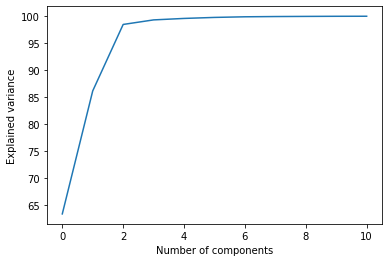

In [38]:
# PCA lemmatization CV
total_components = len(X.columns)
# X_lemmatization_cv
n_components = 3
X_PCA_others = perform_PCA (X, y, total_components, n_components)

In [39]:
X_train_others,X_test_others,y_train_others,y_test_others=split_data_train_test_split(X_PCA_others,y)

In [40]:
from sklearn.svm import SVC
svclassifier_others = SVC(C= 0.1, gamma= 1, kernel= 'rbf',probability=True)
svclassifier_others.fit(X_train_others, y_train_others)
y_pred_others = svclassifier_others.predict(X_test_others)

In [41]:
#Ensemble

In [42]:
for i in range(len(y_pred_text)):
  if y_pred_text[i]==0:
    y_pred_text[i]=-1
# for i in range(len(y_pred_hashtag)):
#   if y_pred_hashtag[i]==0:
#     y_pred_hashtag[i]=-1
for i in range(len(y_pred_bio)):
  if y_pred_bio[i]==0:
    y_pred_bio[i]=-1
for i in range(len(y_pred_others)):
  if y_pred_others[i]==0:
    y_pred_others[i]=-1

In [43]:
# y_pred_text_prob=SVC1.predict_proba(X_test)
# y_pred_hashtag_prob=RF.predict_proba(X_test)
y_pred_bio_prob=svclassifier_bio.predict_proba(X_test_portered_tf_bio)
y_pred_others_prob=svclassifier_others.predict_proba(X_test_others)
y_pred_text_prob = svclassifier_text.predict_proba(X_test_portered_tf_text)
y_pred_hashtag_prob=svclassifier_hashtag.predict_proba(X_test_portered_tf_hashtag)

In [44]:
y_pred_text_prob=[max(y_pred_text_prob[i][0],y_pred_text_prob[i][1]) for i in range(len(y_pred_text_prob))]
y_pred_hashtag_prob=[max(y_pred_hashtag_prob[i][0],y_pred_hashtag_prob[i][1]) for i in range(len(y_pred_hashtag_prob))]
y_pred_bio_prob=[max(y_pred_bio_prob[i][0],y_pred_bio_prob[i][1]) for i in range(len(y_pred_bio_prob))]
y_pred_others_prob=[max(y_pred_others_prob[i][0],y_pred_others_prob[i][1]) for i in range(len(y_pred_others_prob))]

In [45]:
ensembled_acc=np.zeros(len(y_pred_bio_prob))
weight=[1, 1, 1, 1] # Default 1 for now. We could change later
for i in range(len(y_pred_bio_prob)):
  ensembled_acc[i]=weight[0]*(y_pred_text[i] * y_pred_text_prob[i]) + weight[1]*(y_pred_hashtag[i] * y_pred_hashtag_prob[i]) +weight[2]*(y_pred_bio[i] * y_pred_bio_prob[i]) + weight[3]*(y_pred_others[i] * y_pred_others_prob[i]) 
  if ensembled_acc[i]>=0:
    ensembled_acc[i]=1
  else:
    ensembled_acc[i]=0

In [46]:
print("Ensembled Accuracy",accuracy_score(y_test_others,ensembled_acc))
print("Ensembled Precision",precision_score(y_test_others,ensembled_acc))
print("Ensembled Recall",recall_score(y_test_others,ensembled_acc))
print("Ensembled F1",f1_score(y_test_others,ensembled_acc))

# Ensembled Accuracy 0.866822429906542
# Ensembled Precision 0.8047808764940239
# Ensembled Recall 0.9619047619047619
# Ensembled F1 0.876355748373102

Ensembled Accuracy 0.866822429906542
Ensembled Precision 0.8047808764940239
Ensembled Recall 0.9619047619047619
Ensembled F1 0.876355748373102
